In [1]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta, datetime
from logging.config import dictConfig
import pathlib

# data processing and ML libraries
import numpy as np
import pandas as pd
import joblib
import xarray as xr
import dask
from dask.distributed import Client
import optuna
from optuna.integration.dask import DaskStorage
from optuna.integration import LightGBMPruningCallback

# Scikit-learn and model-related imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt

# downscaleml imports
from downscaleml.core.hpo import objective
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset, DatasetStacker, SummaryStatsCalculator, doy_encoding
from downscaleml.core.clustering import ClusteringWorkflow
from downscaleml.main.config_reanalysis_dev import (
    ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH,
    NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
    CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
    OVERWRITE, DEM, DEM_FEATURES, STRATIFY, WET_DAY_THRESHOLD,
    VALID_SIZE, start_year, end_year, CHUNKS
)
from downscaleml.core.constants import (
    ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
    ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
    ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
    PREDICTANDS
)
from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf


In [2]:
# module level logger
LOGGER = logging.getLogger(__name__)

In [3]:
if __name__ == '__main__':

    client = Client()

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    # check if target dataset already exists
    target = target.joinpath(state_file.name + '.nc')
    if target.exists() and not OVERWRITE:
        LogConfig.init_log('{} already exists.'.format(target))
        sys.exit()

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH.joinpath('ERA5'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})
    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])


    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Obs_train.y, 'x': Obs_train.x},
            add_coord={'time': Obs_train.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Obs_train.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Obs_train.chunks)
        Obs_train = xr.merge([Obs_train, dem])

    #statistics_dataset = calculate_statistics_to_dataset(Obs_train)
    LogConfig.init_log(f'To see : {Obs_train}')

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-12T11:19:40: Initializing downscaling for period: 2000-01-01 - 2015-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-12T11:19:40: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/REANALYSIS/ERA5/geopotential, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/REANALYSIS/ERA5/temperature, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-12T11:19:47: Summary statistics loaded along the time dimension : <xarray.Dataset>
Dimensions:            (x: 161, y: 96)
Coordinates:
  * x                  (x) float64 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y                  (y) float64 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
    heightAboveGround  float64 2.0
    quantile           float64 0.95
Data variables:
    dem_mean           (y, x) float32 dask.array<chunksize=(96, 161), meta=np.ndarray>
    dem_max            (y, x) float32 dask.array<chunksize=(96, 161), meta=np.ndarray>
    dem_min            (y, x) float32 dask.array<chunksize=(96, 161), meta=np.ndarray>
    dem_range          (y, x) float32 dask.array<chunksize=(96, 161), meta=np.ndarray>
    dem_variance       (y, x) float32 dask.array<chunksize=(96, 161), meta=np.ndarray>
    temp_max           (y, x) float32 302.5 3

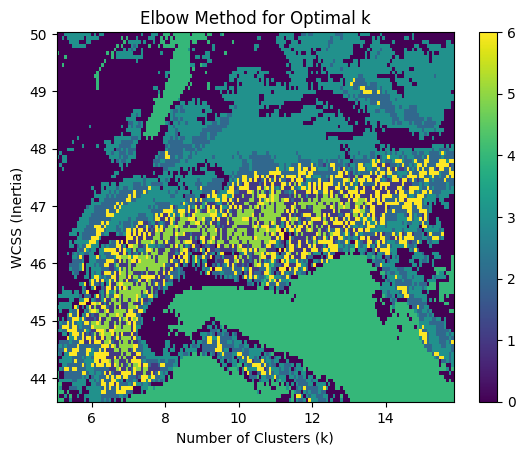

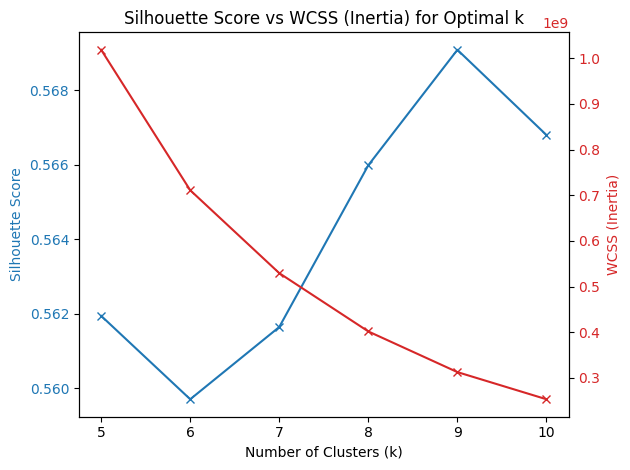

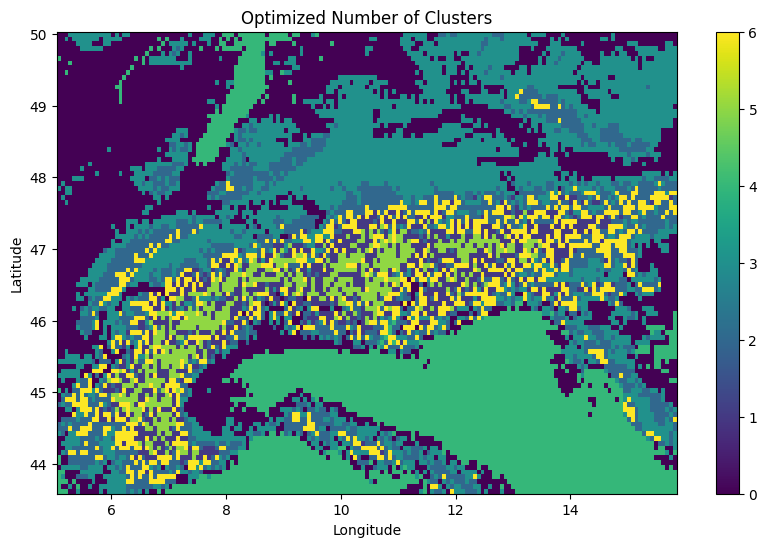

In [4]:
# Create an instance of the class
stats_calculator = SummaryStatsCalculator(Obs_train)

# Compute summary statistics
statistics_dataset = stats_calculator.compute_summary_stats()

LogConfig.init_log(f'Summary statistics loaded along the time dimension : {statistics_dataset}')

lat_lon_flat = statistics_dataset.to_array().stack(points=('y', 'x')).T.values

# Instantiate the workflow and run the full clustering process
clustering = ClusteringWorkflow(data=lat_lon_flat, statistics_dataset=statistics_dataset, min_k=5, max_k=10)
clustered_map = clustering.full_clustering_workflow()

# Log the final clustered map
LOGGER.info(f'Clustered map dataset here: {clustered_map}')


Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
Era5_valid = doy_encoding(Era5_valid, Obs_valid, doy=DOY)

In [5]:
# Assuming Era5_train, Era5_valid, Obs_train, and Obs_valid are already defined xarray datasets
stacker = DatasetStacker(Era5_train)
predictors_train = stacker.stack_spatial_dimensions(compute=True)

stacker = DatasetStacker(Era5_valid)
predictors_valid = stacker.stack_spatial_dimensions(compute=True)

stacker = DatasetStacker(Obs_train.drop_vars("elevation"))
predictand_train = stacker.stack_spatial_dimensions()  # Computed later if needed

stacker = DatasetStacker(Obs_valid)
predictand_valid = stacker.stack_spatial_dimensions()  # Computed later if needed

cluster_py = clustered_map.stack(spatial=('y', 'x')).to_numpy()
cluster_dict = {}

# Get unique values from the data array
unique_values = np.unique(cluster_py)  # Use `.values` to get the raw NumPy array

# Loop through each unique value and capture the indices
for value in unique_values:
    # Get the indices where the value occurs in the DataArray using NumPy
    indices = np.argwhere(cluster_py == value)
    
    # Convert to list of tuples (x, y) and store in the dictionary
    cluster_dict[value] = indices.squeeze()

    LogConfig.init_log(f'Clusters and their shapes: {cluster_dict[value].shape}')

downscaleml.core.dataset: Shape is in (spatial, time, variables): (15456, 5844, 15)
downscaleml.core.dataset: Shape is in (spatial, time, variables): (15456, 366, 15)
downscaleml.core.dataset: Shape is in (spatial, time, variables): (15456, 5844, 1)
downscaleml.core.dataset: Shape is in (spatial, time, variables): (15456, 366, 1)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-12T11:21:44: Clusters and their shapes: (4037,)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-12T11:21:44: Clusters and their shapes: (943,)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: -----------------------------------------------------------------